In [178]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [133]:
!pwd
os.chdir('/content/drive/MyDrive/Colab Notebooks/PyTorch Notebooks/Simple CNN')

/content/drive/MyDrive/Colab Notebooks/PyTorch Notebooks/Simple CNN


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [135]:
transformer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                                  ])

In [136]:
batch_size = 16
train_dataset = datasets.CIFAR10(root='dataset/',train=True, transform=transformer, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root='dataset/',train=False, transform=transformer, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [137]:
print('Train dataset shape: '+str(train_dataset.data.shape))
print('Test dataset shape: '+str(test_dataset.data.shape))

Train dataset shape: (50000, 32, 32, 3)
Test dataset shape: (10000, 32, 32, 3)


In [138]:
classes = train_dataset.classes

In [139]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [140]:
def imshow(img, labels):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # print(img.shape[0])
    # print(npimg.shape)
    num_image = img.shape[0]

    if num_image>4:
      fig, ax = plt.subplots(int(np.ceil(num_image/4)), 4, figsize=(10, 10))
    else:
      fig, ax = plt.subplots(2, 4, figsize=(10, 10))
    # print(ax)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off')
    n=0
    for i in range(int(np.ceil(num_image/4)) if num_image>4 else 2):
      for j in range(4):
        if n < num_image:
          ax[i,j].imshow(np.transpose(img[n],(1,2,0)))
          ax[i,j].set_title(classes[labels[n]])

        ax[i,j].axis('off')
        n+=1


    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

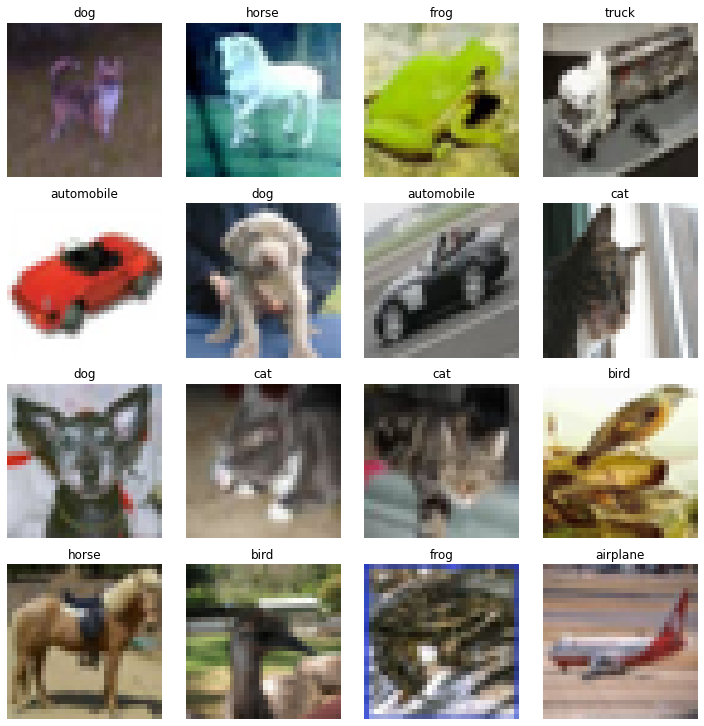

In [193]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images))
imshow(images, labels)

In [181]:
class Net(nn.Module):
    def __init__(self, image_channel_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(image_channel_size, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 1)
        self.fc1 = nn.Linear(256 * 17 * 17, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv5(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(3,10).to(device)

In [213]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [214]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [215]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, net, criterion, optimizer)
    test(test_loader, net, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.205026  [    0/50000]
loss: 0.929606  [ 1600/50000]
loss: 0.722002  [ 3200/50000]
loss: 0.199320  [ 4800/50000]
loss: 0.755260  [ 6400/50000]
loss: 0.612631  [ 8000/50000]
loss: 0.221681  [ 9600/50000]
loss: 0.768539  [11200/50000]
loss: 0.644406  [12800/50000]
loss: 0.523589  [14400/50000]
loss: 0.753832  [16000/50000]
loss: 0.618821  [17600/50000]
loss: 0.918682  [19200/50000]
loss: 1.132675  [20800/50000]
loss: 0.627145  [22400/50000]
loss: 0.766887  [24000/50000]
loss: 0.150050  [25600/50000]
loss: 0.820944  [27200/50000]
loss: 0.440207  [28800/50000]
loss: 0.185744  [30400/50000]
loss: 0.303393  [32000/50000]
loss: 0.391969  [33600/50000]
loss: 0.407920  [35200/50000]
loss: 0.422885  [36800/50000]
loss: 0.678167  [38400/50000]
loss: 0.605591  [40000/50000]
loss: 0.273801  [41600/50000]
loss: 0.728533  [43200/50000]
loss: 0.454625  [44800/50000]
loss: 0.299962  [46400/50000]
loss: 0.273091  [48000/50000]
loss: 0.714675  [49600/50000]


In [ ]:
datatestiter = iter(test_loader)
images, labels = datatestiter.next()

# print images


outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
p = [predicted[j] for j in range(16)]
print(p)
testimshow(images, labels, p)

In [210]:
def testimshow(img, labels, preds):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # print(img.shape[0])
    # print(npimg.shape)
    num_image = img.shape[0]

    if num_image>4:
      fig, ax = plt.subplots(int(np.ceil(num_image/4)), 4, figsize=(10, 10))
    else:
      fig, ax = plt.subplots(2, 4, figsize=(10, 10))
    # print(ax)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off')
    n=0
    for i in range(int(np.ceil(num_image/4)) if num_image>4 else 2):
      for j in range(4):
        if n < num_image:
          ax[i,j].imshow(np.transpose(img[n],(1,2,0)))
          ax[i,j].set_title(classes[labels[n]]+" "+classes[preds[n]])

        ax[i,j].axis('off')
        n+=1


    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()